# Ridge and Lasso Regression

Changes to be made wrt `LinReg` class implemented earlier
1. Loss Function(`loss`): $ J(w) = \frac{1}{2}(Xw - y)^T(Xw - y) + \frac{\lambda}{2}w^T w $
2. Gradient(`calculate_gradient`): $\frac{\partial J(w)}{\partial w} = X^T (Xw - y) + \lambda w$
3. Normal equation(`fit`): $w = (X^TX + \lambda I)^{-1}X^Ty$

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
class LinReg(object):
    '''
    Linear regression Model
    ------------------------------------
    y = X@w
    X: A feature matrix
    w: weight vector
    y; Label Vector
    '''

    def __init__(self):
        self.t0 = 200
        self.t1 = 100000

    def predict(self, X:np.ndarray) -> np.ndarray:
        ''' Prediction of ouotput label for a given input

            Args:
                X: Feature matrix of shape (n, m+1).
                w: weight vector of shape (m+1,)

            Returns:
                y: Predicted label vector of shape (n,) 

        '''

        y = X @ self.w
        return y

    def loss(self, X: np.ndarray, y: np.ndarray, reg_rate: float) -> float:
        '''Calculates loss for a model based on known labels
    
        Args:
            X: Feature matrix for given inputs
            y: Output label vector as predicted by the given model
            w: Weight vector

        Returns:
            Loss
        '''

        err = self.predict(X) - y
        #return (1/2) * (np.transpose(err) @ err)
        return (1/2) * (np.transpose(err) @ err) + (reg_rate/2) * (np.transpose(self.w) @ self.w)

    def rmse(self, X: np.ndarray, y: np.ndarray, reg_rate:float) -> float:
        '''Calculate root mean square error of prediction wrt actual label.
        
        Args:
            X: Feature matrix for the given inputs
            y: output label vector as predicted by the given model

        Returns:
            Loss
        '''

        return np.sqrt((2/X.shape[0]) * self.loss(X, y, reg_rate))

    def fit(self, X:np.ndarray, y:np.ndarray, reg_rate: float) -> float:
        '''Estimates parameters of the linear regression model with normal equation.
    
        Args: 
            X: Feature matrix for given inputs.
            y: Actual label vector.

        Returns:
            Weight vector
        '''
        self.w = np.zeros((X.shape[1]))
        eye = np.eye(np.size(X,1))
        self.w = np.linalg.solve(reg_rate * eye + X.T @ X, X.T @ y,)
        return self.w

    def calculate_gradient(self, X:np.ndarray, y:np.ndarray, reg_rate: float) -> np.ndarray:
        '''Calculates gradients of loss dunction wrt weight vector on training set
    
        Arguments:

            X: Feature matrix for training data.
            y: Label vector for training data
            w: Weight vector

        Returns:
            A vector of gradients.
        '''

        return np.transpose(X) @ (self.predict(X) - y) + reg_rate * self.w
    
    def update_weights(self, grad: np.ndarray, lr: float) -> np.ndarray:
        '''
        Updates the weights based on the gradient of loss function.

        Weight updates are carried out with the fiollowing formula:
            w_new := w_old - lr * grad

        Args:
            1. w: Weight vector
            2. grad: gradient of loss w.r.t w
            3. lr: learning rate

        Returns:
            Updated weight vector
        '''

        return (self.w - lr*grad)

    def learning_schedule(self, t) -> float:
        lr = (self.t0) / (t + self.t1)
        return lr

    def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float, reg_rate: float) -> np.ndarray:
        '''Estimates parameters of linear regression model through gradient descent.
    
        Arguments:
            X: Feature matrix for training data
            y: Label vector for training data
            lr: learning rate
            num_epochs: Number of training steps

        Returns:
            Weight vector: Final weight vector
            Error vector across different iterations
            Weight vectors acrss different iterations
        '''
        self.w = np.zeros((X.shape[1])) # parameter vector initialised to zero
        self.w_all = [] #all paramenter across iterations
        self.err_all = [] # all arrors across iterations



        #Gradient descent loop
        for i in np.arange(0, num_epochs):

            #Gradient Calulation
            dJdW = self.calculate_gradient(X, y, reg_rate)

            self.w_all.append(self.w)

            #calculate arror due to the current weight vector:
            self.err_all.append(self.loss(X, y, 0))

            #Weight vector update.
            self.w = self.update_weights(dJdW, lr)

        return self.w
    
    def mbgd(self, X: np.ndarray, y: np.ndarray, num_epochs: int, batch_size: int, reg_rate: float) -> np.ndarray:

        '''Estimates parametrs of linear regression model through gradient descent.
    
        Args:
            1. X: Feature matrix for training data.
            2. y: Label vector for training data.
            3. num_iters: Number of iterations.

        Returns:
            Weight vector: Final weight vector
            Error vector across different iterations
         Weight vector acosss different iterations
        
        '''
        # Parameter vector initialised to [0,0]
        self.w = np.zeros((X.shape[1]))
        
        self.w_all = [] # all parameters across iterations.
        self.err_all = [] # error across iterations

        mini_batch_id = 0

        for epoch in range(num_epochs):
            shuffled_indices = np.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                xi = X_shuffled[i: i + batch_size]
                yi = y_shuffled[i: i + batch_size]
            
                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi, yi, 0))

                dJdW = 2/batch_size * self.calculate_gradient(xi, yi, reg_rate)

                self.w = self.update_weights(dJdW, self.learning_schedule(mini_batch_id))
            
        return self.w
    
    def sgd(self, X: np.ndarray, y: np.ndarray, num_epochs: int, reg_rate: float) -> np.ndarray:

        '''Estimates parametrs of linear regression model through stochastic gradient descent.
    
        Args:
            1. X: Feature matrix for training data.
            2. y: Label vector for training data.
            3. num_epochs: Number of epochs.

        Returns:
            Weight vector: Final weight vector
            Error vector across different iterations
            Weight vector acosss different iterations
        '''

        self.w_all = [] # all parameters across iterations.
        self.err_all = [] # error across iterations

        # Parameter vector initialised to [0,0]
        self.w = np.zeros((X.shape[1]))

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index = np.random.randint(X.shape[0])
                xi = X[random_index: random_index + 1]
                yi = y[random_index: random_index + 1]
            
                self. err_all.append(self.loss(xi, yi, 0))
                self.w_all.append(self.w)

                gradients = 2 * self.calculate_gradient(xi, yi, reg_rate)
                lr = self.learning_schedule(epoch * X.shape[0] + i)

                self.w = self.update_weights(gradients, lr)
            

        return self.w

In [36]:
import unittest

class TestLossFunction((unittest.TestCase)):
    
    def test_loss_function(self):
        '''Test case for loss function of linear regression'''

        # Set up
        feature_matrix = np.array([[1,3,2,5],[1,9,4,7]])
        weight_vector = np.array([1,1,1,1])
        label_vector = np.array([6,11])
        reg_rate = 0.01
        expected_loss = np.array([62.52])

        # call
        lin_reg = LinReg()
        lin_reg.w = weight_vector
        loss_value = lin_reg.loss(feature_matrix, label_vector, reg_rate)

        #asserts
        #test the shape
        self.assertEqual(loss_value.shape, ())

        #and contents
        np.testing.assert_array_equal(expected_loss, loss_value)

unittest.main(argv=[''], defaultTest = 'TestLossFunction', verbosity = 2, exit=False)

test_loss_function (__main__.TestLossFunction)
Test case for loss function of linear regression ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [37]:
import unittest

class TestCalculateGradient(unittest.TestCase):

    def test_calculate_gradient(self):

        '''
        Test case for gradient descent
        '''

        #Set up
        feature_matrix = np.array([[1,3,2,5],[1,9,4,7]])
        weight_vector = np.array([1,1,1,1])
        label_vector = np.array([6,11])
        reg_rate = 0.01
        expected_grad = np.array([15,105,50,95])

        #Call
        lin_reg = LinReg()
        lin_reg.w = weight_vector
        grad = lin_reg.calculate_gradient(feature_matrix, label_vector, reg_rate)

        #asserts
        #test the shape
        self.assertEqual(grad.shape, (4, ))

        #and contents
        np.testing.assert_array_almost_equal(expected_grad, grad, decimal=0)

unittest.main(argv=[''], defaultTest='TestCalculateGradient', verbosity=2,exit=False)

test_calculate_gradient (__main__.TestCalculateGradient)
Test case for gradient descent ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


## Ridge Regularisation for fixing overfitting in polynomial regression 

In [58]:
import itertools
import functools

def get_combinations(x, degree):
    return itertools.combinations_with_replacement(x, degree)

def compute_new_features(items):
    #reduce(lambda x, y: x * y, items, [1,2,3,4,5]) calculates ((((1*2)*3)*4)*5)
    return functools.reduce(lambda x, y: x * y, items)

def polynomial_transform(x, degree, logging=False):
    # Converts to feature matrix.
    if x.ndim == 1:
        x = x[:, None]

    x_t = x.transpose() #transposes the feature matrix
    features = [np.ones(len(x))] # populates 1s as the first features

    if logging:
        print ("Input:", x)
    
    for degree in range(1, degree+1):
        for items in get_combinations(x_t, degree):
            features.append(compute_new_features(items))
            if logging:
                print (items, ":", compute_new_features(items))

    if logging:
        print(np.asarray(features).transpose())

    return np.asarray(features).transpose()

def create_nonlin_training_set(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    y = func(x) + np.random.normal(scale=std, size = x.shape)

    return x, y

def nonlin(x):
    return np.sin(2 * np.pi * x)

def visualize_training_data(X_train, y_train):
    points = np.linspace(0, 1, 100)
    output = nonlin(points)

    plt.scatter(X_train, y_train, facecolor="none", edgecolors="b", s= 50, label='training data')
    plt.plot(points, output, c='g', label="$\sin(2\pi x)$")
    plt.xlabel('$x_1$')
    plt.ylabel('y')
    plt.legend()
    plt.show()

def visualise_model_fit(X, y, lin_reg, degree, reg_rate):
    '''plots trained model along with the data genration function'''

    points = np.linspace(0, 1, 100)
    output = nonlin(points)

    if degree > 0:
        plt.scatter(X, y, facecolor="none", edgecolors="b", s =50, label ='training data')

    plt.plot(points, output, c="g", label = "$\sin(2\pi x)$")

    y_hat = lin_reg.predict(polynomial_transform(points, degree))
    plt.plot(points, y_hat, c="r", label="$h_\mathbf{w}(x)$") 
    plt.xlabel('$x_1$')
    plt.ylabel('y')
    plt.ylim(-1.5, 1.5)
    plt.title("M={} $\lambda = {}$".format(degree, reg_rate))

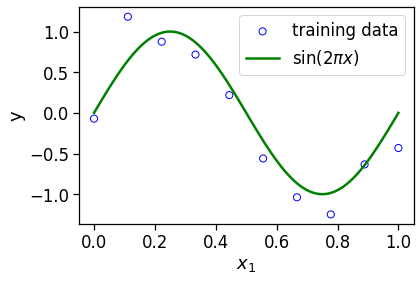

In [59]:
num_samples = 10
X, y = create_nonlin_training_set(nonlin, num_samples, 0.2)
visualize_training_data(X, y)


### Polynomial models without regularisation

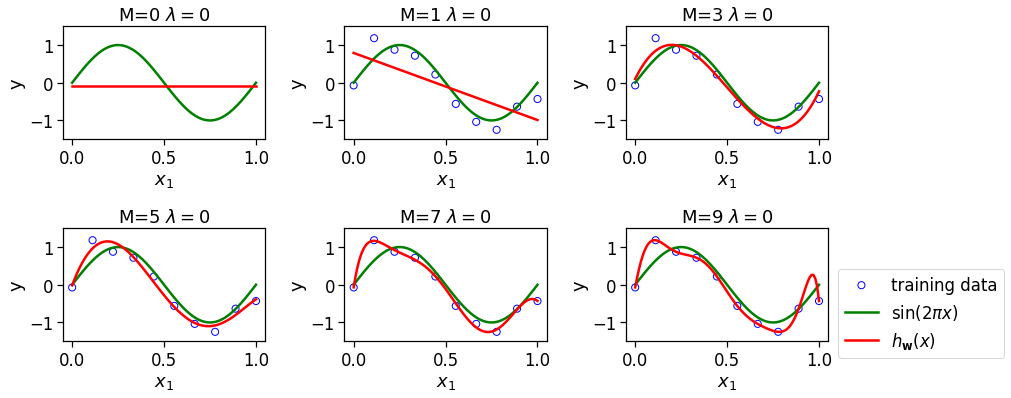

In [60]:
f = plt.figure(figsize=(12, 8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i, degree in enumerate([0,1,3,5,7,9]):
    plt.subplot(3, 3, i+1)
    X_transform = polynomial_transform(X, degree)
    lin_reg = LinReg()
    lin_reg.fit(X_transform, y, reg_rate = 0)
    visualise_model_fit(X, y, lin_reg, degree, reg_rate = 0)

f.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()

### Ridge regression

$ \lambda = 0.01 $

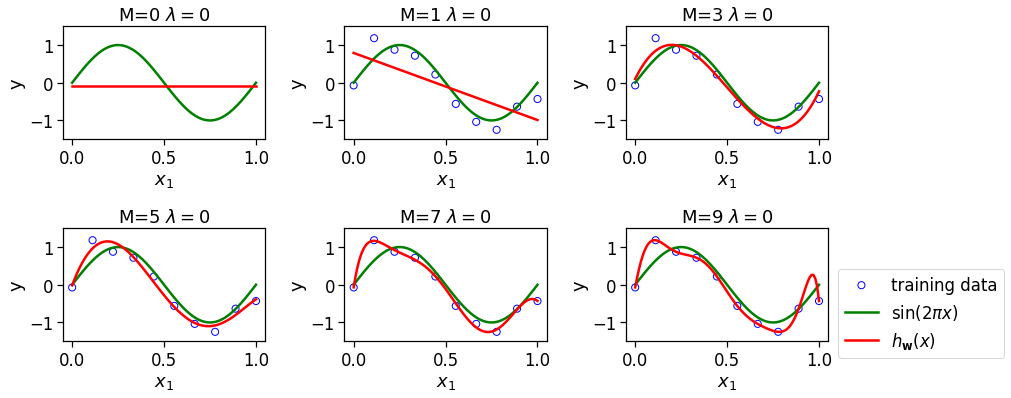

In [61]:
f = plt.figure(figsize=(12, 8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i, degree in enumerate([0,1,3,5,7,9]):
    plt.subplot(3, 3, i+1)
    X_transform = polynomial_transform(X, degree)
    lin_reg = LinReg()
    lin_reg.fit(X_transform, y, reg_rate = 0)
    visualise_model_fit(X, y, lin_reg, degree, reg_rate = 0)

f.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()

Let's run a polynomial regression of degree =9 with different regularisation rate.

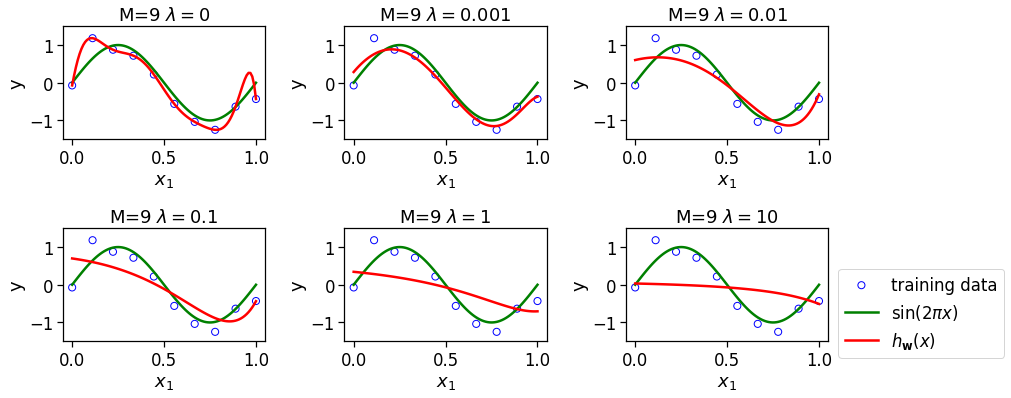

In [62]:
f = plt.figure(figsize=(12, 8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i, reg_rate in enumerate([0, 1e-3, 1e-2, 1e-1, 1, 10]):
    plt.subplot(3, 3, i+1)
    X_transform = polynomial_transform(X, degree)
    lin_reg = LinReg()
    lin_reg.fit(X_transform, y, reg_rate = reg_rate)
    visualise_model_fit(X, y, lin_reg, degree, reg_rate = reg_rate)

f.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()

### Model Selection

* One model per $\lambda$. Which one to select?
* Process
    * Fix the list of $\lambda$ you want to experiment with.
    * Divide the training data into training, validation and test.
    * For each $\lambda$:
        * Train polynomial regression model with training data
        * Calculate training and validation errors on the trained model
    * Select the model with the lowest training and validation loss among all models

In [63]:
import pandas as pd

def plot_reg_w(w_df):
    ax = plt.gca()
    ax.plot(w_df.T)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.xlabel('$\lambda$')
    plt.ylabel('$\mathbf{w}$')
    plt.title('Weights as a function of $\lambda$')
    plt.axis('tight')
    plt.show()

def plot_learning_curve(err_df):
    ax = plt.gca()
    ax.plot(err_df)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.xlabel('$\lambda$')
    plt.ylabel('$RMSE$')
    plt.title('Training and validation loss as a function of $\lambda$')
    plt.axis('tight')
    plt.legend(['training', 'validation'])
    plt.show()

In [64]:
training_errors = {}
val_errors = {}
w_dict = {}
degree = 9

X_val = np.linspace(0, 1, 100)
y_val = nonlin(X_val)
 
X_transform = polynomial_transform(X, degree)
X_val_transform = polynomial_transform(X_val, degree)

for reg_rate in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]:   
    lin_reg = LinReg()
    lin_reg.fit(X_transform, y, reg_rate)

    w_dict[reg_rate] = lin_reg.w
    training_errors[reg_rate] = lin_reg.rmse(X_transform, y, reg_rate)
    val_errors[reg_rate] = lin_reg.rmse(X_val_transform, y_val + np.random.normal(scale=0.25, size=len(y_val)), reg_rate)

err_df = pd.DataFrame([training_errors, val_errors]).T
w_df = pd.DataFrame(w_dict)

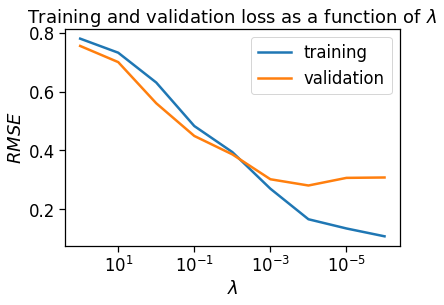

In [65]:
plot_learning_curve(err_df)

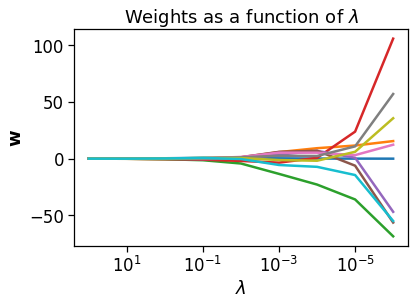

In [66]:
plot_reg_w(w_df)

## Lasso regression

Lasso uses $L_1$ norm of weight vector instead of $L_2$ as used in ridge regression.

Lasso doesn't have a closed form solution and it's loss function is not differentiable at all points. We need to use specialised algorithm  to learn lasso parameters. We will use sklearn Lasso implementation

In [67]:
from sklearn.linear_model import Lasso

#Lasso
reg_rate = 0.01
lasso = Lasso(alpha = reg_rate)
lasso.fit(X_transform, y)

#Linear regression
lin_reg = LinReg()
_ = lin_reg.fit(X_transform, y, 0)

Let's compare weight vectors of linear, ridge and lasso regression

In [68]:
pd.DataFrame({'LinReg': lin_reg.w, 'Ridge': w_df[0.01], 'Lasso': lasso.coef_})

,LinReg,Ridge,Lasso
0,-0.071147,0.601752,0.000000
1,26.173301,1.144795,-0.000000
2,-113.176135,-4.288589,-2.884214
3,-914.816368,-2.018011,-0.000000
4,9974.388280,0.135970,0.000000
5,-38479.280247,1.249627,0.000000
6,77256.862455,1.501405,0.000000
7,-85928.303834,1.180647,0.000000
8,50246.830889,0.516970,0.000000
9,-12069.039063,-0.331712,1.782235


**Observations:**
1. Lasso obtains a sparse weight vector. 
2. Ridge regression assigns small weights to each feaature.

* Lasso is used for feature selection
* While modelling relationship between features and labels,
    * When all features are useful, use ridge regression
    * When only a few features are useful, use lasso

Let's visualize these three models:

Text(0.5, 1.0, 'Lasso (M=9, $\\lambda=0.01$)')

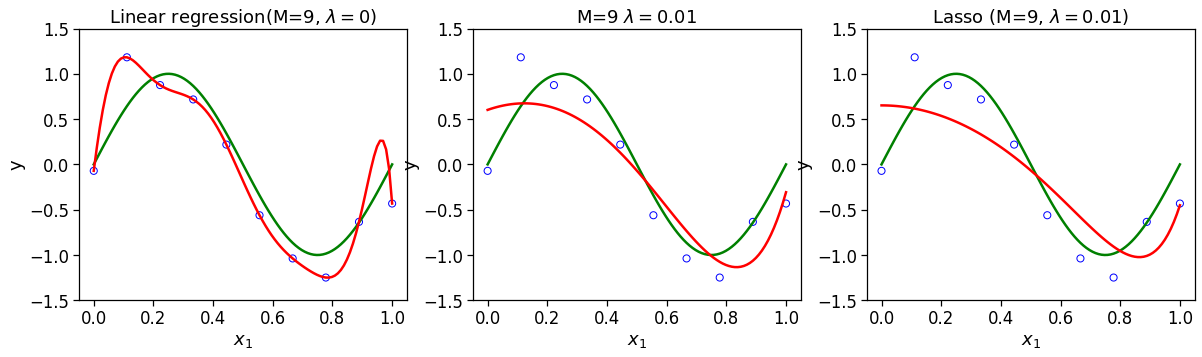

In [69]:
f = plt.figure(figsize=(20,5))
ax1 = plt.subplot(1,3,1)
degree = 9

visualise_model_fit(X, y, lin_reg, degree, reg_rate=0)
plt.title('Linear regression(M=9, $\lambda=0$)')

lin_reg.w = w_df[0.01]
ax2 = plt.subplot(1, 3, 2)
visualise_model_fit(X, y, lin_reg, degree, reg_rate=0.01)

ax3 = plt.subplot(1,3,3)
visualise_model_fit(X, y, lasso, degree, reg_rate=0.01)
plt.title('Lasso (M=9, $\lambda=0.01$)')

Let's look at lasso with different regularisation rates

C:\Users\viswa\AppData\Local\Temp\ipykernel_16420\3380090515.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_transform, y)
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.610e-02, tolerance: 6.173e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages

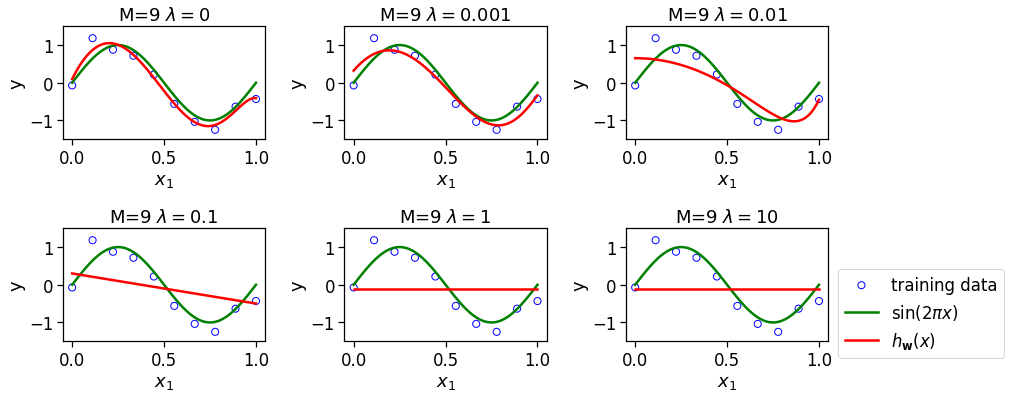

In [70]:
f = plt.figure(figsize=(12, 8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

degree = 9
X_transform = polynomial_transform(X, degree)

for i, reg_rate in enumerate([0, 1e-3, 1e-2, 1e-1, 1, 10]):
    plt.subplot(3, 3, i + 1)
    lasso = Lasso(alpha=reg_rate)
    lasso.fit(X_transform, y)
    visualise_model_fit(X, y, lasso, degree, reg_rate)

f.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 0.64), loc =2, borderaxespad=0.)
plt.show()

## Model selection

In [73]:
from sklearn.metrics import mean_squared_error

training_errors = {}
val_errors = {}
w_dict = {}
degree = 9

X_val = np.linspace(0, 1, 100)
y_val = nonlin(X_val)
 
X_transform = polynomial_transform(X, degree)
X_val_transform = polynomial_transform(X_val, degree)

for reg_rate in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]:   
    lasso = Lasso(alpha=reg_rate)
    lasso.fit(X_transform, y, reg_rate)

    w_dict[reg_rate] = lasso.coef_

    training_errors[reg_rate] = mean_squared_error(y, lasso.predict(X_transform), squared=False)
    val_errors[reg_rate] = mean_squared_error( y_val + np.random.normal(scale=0.25, size=len(y_val)), lasso.predict(X_val_transform), squared=False)

err_df = pd.DataFrame([training_errors, val_errors]).T
w_df = pd.DataFrame(w_dict)

c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.605e-02, tolerance: 6.173e-04
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.554e-02, tolerance: 6.173e-04
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.763e-02, tolerance: 6.173e-04
  model = cd_fast.enet_

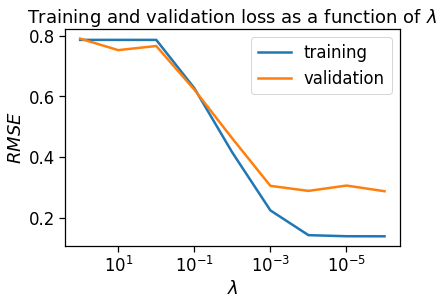

In [74]:
plot_learning_curve(err_df)

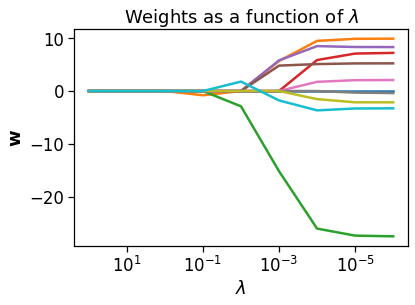

In [75]:
plot_reg_w(w_df)